In [1]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from fiona.crs import from_epsg
from geopandas.tools import overlay

In [2]:
from shapely.geometry import Polygon

polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2)]),
                        Polygon([(0,0), (2,2), (0,2)])])

polys2 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,1), (0,1)]),
                        Polygon([(0,1), (1,1), (1,2), (0,2)]),
                        Polygon([(2,2), (1,2), (1,1), (2,1)])])

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2,3]})

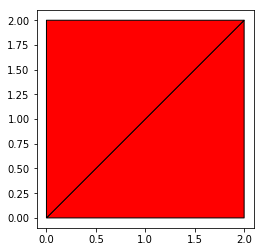

In [3]:
ax = df1.plot(color='red', edgecolor='k')

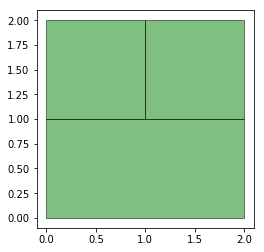

In [4]:
df2.plot(color='green', alpha=0.5, edgecolor='k')
plt.show()

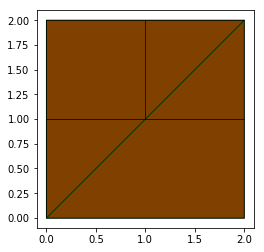

In [5]:
ax = df1.plot(color='red', edgecolor='k')
df2.plot(ax=ax, color='green', alpha=0.5, edgecolor='k')
plt.show()

In [6]:
#Function for overlay
def spatial_overlays(df1, df2, how='intersection', reproject=True):
    """Perform spatial overlay between two polygons.

    Currently only supports data GeoDataFrames with polygons.
    Implements several methods that are all effectively subsets of
    the union.

    Parameters
    ----------
    df1 : GeoDataFrame with MultiPolygon or Polygon geometry column
    df2 : GeoDataFrame with MultiPolygon or Polygon geometry column
    how : string
        Method of spatial overlay: 'intersection', 'union',
        'identity', 'symmetric_difference' or 'difference'.
    use_sindex : boolean, default True
        Use the spatial index to speed up operation if available.

    Returns
    -------
    df : GeoDataFrame
        GeoDataFrame with new set of polygons and attributes
        resulting from the overlay

    """
    from functools import reduce
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if df1.crs!=df2.crs and reproject:
        print('Data has different projections.')
        print('Converted data to projection of first GeoPandas DatFrame')
        df2.to_crs(crs=df1.crs, inplace=True)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['sidx'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('sidx')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        dfinter.drop(['idx1','idx2'], inplace=True, axis=1)
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                 [x.geometry]+list(df2.iloc[x.sidx].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'sidx', 'new_g'], axis=1, inplace=True)
        return df1
    elif how=='symmetric_difference':
        df1['idx1'] = df1.index.tolist()
        df2['idx2'] = df2.index.tolist()
        df1['idx2'] = np.nan
        df2['idx1'] = np.nan
        dfsym = df1.merge(df2, on=['idx1','idx2'], how='outer', suffixes=['_1','_2'])
        dfsym['geometry'] = dfsym.geometry_1
        dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry'] = dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry_2']
        dfsym.drop(['geometry_1', 'geometry_2'], axis=1, inplace=True)
        dfsym = gpd.GeoDataFrame(dfsym, columns=dfsym.columns, crs=df1.crs)
        spatial_index = dfsym.sindex
        dfsym['bbox'] = dfsym.geometry.apply(lambda x: x.bounds)
        dfsym['sidx'] = dfsym.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        dfsym['idx'] = dfsym.index.values
        dfsym.apply(lambda x: x.sidx.remove(x.idx), axis=1)
        dfsym['new_g'] = dfsym.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                         [x.geometry]+list(dfsym.iloc[x.sidx].geometry)) , axis=1)
        dfsym.geometry = dfsym.new_g
        dfsym = dfsym.loc[dfsym.geometry.is_empty==False].copy()
        dfsym.drop(['bbox', 'sidx', 'idx', 'idx1','idx2', 'new_g'], axis=1, inplace=True)
        return dfsym
    elif how=='union':
        dfinter = spatial_overlays(df1, df2, how='intersection')
        dfsym = spatial_overlays(df1, df2, how='symmetric_difference')
        dfunion = dfinter.append(dfsym)
        dfunion.reset_index(inplace=True, drop=True)
        return dfunion
    elif how=='identity':
        dfunion = spatial_overlays(df1, df2, how='union')
        cols1 = df1.columns.tolist()
        cols2 = df2.columns.tolist()
        cols1.remove('geometry')
        cols2.remove('geometry')
        cols2 = set(cols2).intersection(set(cols1))
        cols1 = list(set(cols1).difference(set(cols2)))
        cols2 = [col+'_1' for col in cols2]
        dfunion = dfunion[(dfunion[cols1+cols2].isnull()==False).values]
        return dfunion

# overlay

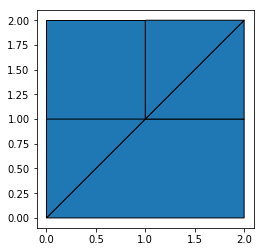

In [7]:
dfo = spatial_overlays(df1, df2)
dfo.plot(edgecolor='k')

In [8]:
dfo.shape

(5, 3)

In [9]:
dfo

,df1,df2,geometry
3,2,2,"POLYGON ((0 1, 0 2, 1 2, 1 1, 0 1))"
1,1,1,"POLYGON ((0 0, 1 1, 2 1, 2 0, 0 0))"
4,2,1,"POLYGON ((0 0, 0 1, 1 1, 0 0))"
2,1,3,"POLYGON ((1 1, 2 2, 2 1, 1 1))"
5,2,3,"POLYGON ((1 2, 2 2, 1 1, 1 2))"


# sjoin

In [10]:
dfs = gpd.sjoin(df1, df2, how='inner', op='intersects')

In [11]:
dfs

,df1,geometry,index_right,df2
0,1,"POLYGON ((0 0, 2 0, 2 2, 0 0))",1,2
1,2,"POLYGON ((0 0, 2 2, 0 2, 0 0))",1,2
0,1,"POLYGON ((0 0, 2 0, 2 2, 0 0))",0,1
1,2,"POLYGON ((0 0, 2 2, 0 2, 0 0))",0,1
0,1,"POLYGON ((0 0, 2 0, 2 2, 0 0))",2,3
1,2,"POLYGON ((0 0, 2 2, 0 2, 0 0))",2,3


In [13]:
dfs.shape

(6, 4)

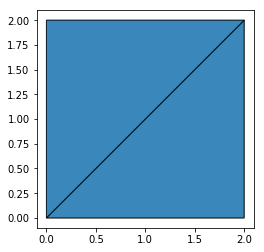

In [14]:
dfs.plot(edgecolor='k', alpha=0.5)